For reference on LaTeX: https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/

# Chapter 5: Prisoners of the Dilemma

## 5.5 Win-Stay Lose-Shift

- Reference: 
Nowak, M. A. & K. Sigmund (1993). A strategy of win-stay, lose-shift that outperforms tit-for-tat in the Prisoner’s Dilemma game. Nature 364: 56-58. DOI: 10.1038/364056a0 [PDF](https://ped.fas.harvard.edu/files/ped/files/nature93_0.pdf)

- Simulation approach (as described on page 87)
    - start with a homogeneous population with strategy (1/2, 1/2, 1/2, 1/2)
    - every 100 generations, inject a small number of new population with a mutatant strategy, according to U-shaped distribution (which biases to the corner or bounday since most relevant strategies are around there)

- **The one we are taking here**
    - Use the same one as the Generous TFT (since we have the computing power needed)
    - M=4. Strategy space for (p1,p2,p3,p4) will be M^4 = 256. Payoff matrix will the size of: M^8=65536
    - M=3. Strategy space will be M^4 = 81. Payoff matrix will have the size of: M^8=6561
    - M=2. Strategy space will be M^4 = 16. Payoff matrix will have the size of: M^8=256
    
    - ask Kelly to play the code with different parameters (random seed, ...) and observe/interpret what happens

In [1]:
%matplotlib inline

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint  # Ordinary Differential Equation


In [2]:
%%time
# create payoff matrix for win-stay lose-shift experiment

R, S, T, P = 3, 0, 5, 1 # Reward, Suck, Temptation, Punishment

M = 4
N = M**4 # number of all possible strategies

proba_list = np.linspace(0.01, .99, M)
print(proba_list)

debug = 0
# debug = 1

from scipy.linalg import eig

def payoff(p1, p2, p3, p4, p1_, p2_, p3_, p4_): # payoff of strategy (p1,p2,p3,p4) against (p1_,p2_,p3_,p4_)
    markov = np.array([
    [ p1*p1_, p1*(1-p1_), (1-p1)*p1_, (1-p1)*(1-p1_) ],
    [ p2*p3_, p2*(1-p3_), (1-p2)*p3_, (1-p2)*(1-p3_) ],
    [ p3*p2_, p3*(1-p2_), (1-p3)*p2_, (1-p3)*(1-p2_) ],
    [ p4*p4_, p4*(1-p4_), (1-p4)*p4_, (1-p4)*(1-p4_) ] ])
    
#     print(markov)
    
    # copied from https://stackoverflow.com/questions/31791728/python-code-explanation-for-stationary-distribution-of-a-markov-chain
    evals, evecs = np.linalg.eig(markov.T)
    evec1 = evecs[:,np.isclose(evals, 1)]

    #Since np.isclose will return an array, we've indexed with an array
    #so we still have our 2nd axis.  Get rid of it, since it's only size 1.
    evec1 = evec1[:,0]
    stationary = evec1 / evec1.sum()

    #eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
    stationary = stationary.real
#     print(stationary)
#     print(stationary.dot(markov))
#     return
    
    v1, v2, v3, v4 = stationary
    result = R*v1 + S*v2 + T*v3 + P*v4
    return result

def convert_number(n, base):
    remainders = [0]*4 # 4 dimension
    i = 0
    while n>0: 
        n, r = divmod(n, base)
        remainders[i] = r
        i += 1
    return remainders[::-1]

def add_noise(*arr): return [e+np.random.uniform(0,0.01) for e in arr]

def compute_payoff_between_i_and_j(i, j): # both i and j are in the range of (0, 1, ..., N=M**4-1)    
    i1, i2, i3, i4 = convert_number(i, M)
    j1, j2, j3, j4 = convert_number(j, M)
    
    p1, p2, p3, p4 = proba_list[i1], proba_list[i2], proba_list[i3], proba_list[i4]
    p1_, p2_, p3_, p4_ = proba_list[j1], proba_list[j2], proba_list[j3], proba_list[j4]
    
    if 1:
        np.random.seed(123)
        p1, p2, p3, p4 = add_noise(p1, p2, p3, p4)
        p1_, p2_, p3_, p4_ = add_noise(p1_, p2_, p3_, p4_)
    
    expected_payoff = payoff(p1, p2, p3, p4, p1_, p2_, p3_, p4_)
    
    if debug:
        print(f'[i={i:02d}] ({i_row}, {i_col}) ({p1:.3f}, {q1:.3f}) vs. [j={j:02d}] ({j_row}, {j_col}) ({p2:.3f}, {q2:.3f})  payoff: {expected_payoff:.2f}' )
    return expected_payoff
    
    
payoff_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        payoff_matrix[i, j] = compute_payoff_between_i_and_j(i, j)
#         break
#     break


[0.01  0.337 0.663 0.99 ]
CPU times: user 7.45 s, sys: 15.6 ms, total: 7.47 s
Wall time: 7.46 s


In [3]:
df_payoff = pd.DataFrame(payoff_matrix)
if M==2:
    display(df_payoff.round(2))
else:
    display(pd.DataFrame(payoff_matrix[:10,:20]).round(2))
    save_payoff_matrix = 0
    if save_payoff_matrix:
        df_payoff.to_csv(f'payoff_matrix_WSLS_{M}.csv', index=False, float_format="%.3f")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.05,2.00,2.59,2.98,1.07,2.02,2.59,2.98,1.09,2.03,2.60,2.99,1.11,2.04,2.60,2.99,1.08,2.33,2.98,3.37
1,0.81,1.60,2.19,2.65,1.13,1.75,2.25,2.66,1.40,1.90,2.31,2.66,1.64,2.03,2.37,2.67,0.84,1.83,2.50,2.98
2,0.67,1.29,1.84,2.33,1.16,1.57,1.96,2.34,1.56,1.81,2.07,2.35,1.88,2.02,2.18,2.35,0.69,1.41,2.02,2.54
3,0.57,1.05,1.53,2.01,1.18,1.43,1.71,2.02,1.65,1.75,1.88,2.03,2.01,2.02,2.03,2.04,0.59,1.07,1.55,2.02
4,1.05,1.85,2.29,2.57,1.07,1.93,2.38,2.65,1.11,2.02,2.47,2.73,1.15,2.13,2.57,2.83,1.07,2.10,2.59,2.88
5,0.81,1.52,2.03,2.40,1.14,1.71,2.14,2.46,1.46,1.91,2.26,2.54,1.78,2.12,2.39,2.63,0.83,1.69,2.25,2.65
6,0.66,1.26,1.77,2.21,1.17,1.55,1.91,2.25,1.61,1.83,2.07,2.31,2.01,2.11,2.23,2.37,0.68,1.35,1.90,2.36
7,0.57,1.05,1.52,2.00,1.19,1.43,1.70,2.01,1.70,1.78,1.89,2.03,2.13,2.11,2.08,2.05,0.58,1.06,1.54,2.01
8,1.04,1.73,2.06,2.26,1.08,1.85,2.18,2.37,1.13,2.02,2.34,2.51,1.25,2.26,2.54,2.67,1.06,1.93,2.33,2.56
9,0.81,1.46,1.89,2.19,1.14,1.67,2.02,2.28,1.54,1.93,2.20,2.40,2.01,2.25,2.43,2.57,0.82,1.60,2.08,2.42


max freq: 0.49    min freq: -0.00
x_hist.shape = (255, 256)


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.04,0.02,0.01,0.00,0.01,0.01,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.05,0.02,0.01,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.05,0.01,0.00,0.00,0.01,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


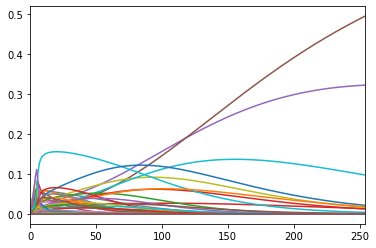

In [4]:
def f(x, t):
    payoff_vector = payoff_matrix.dot(x)
    phi = x.dot(payoff_vector)
#     print(f'{phi:.1f}', end=' ')
    dx = x*(payoff_vector - phi)
    return dx

stop, cnt = 20*N, 5*N-1
stop, cnt = 3*N, N-1
if N<=30:
    stop, cnt = 500, 99
t = np.linspace(0, stop, cnt)
x_init = np.ones(N)/N

x_hist = odeint(f, x_init, t)

print(f'max freq: {x_hist.max():.2f}    min freq: {x_hist.min():.2f}')
print('x_hist.shape =', x_hist.shape)


df = pd.DataFrame(x_hist[:, :])
df.plot(legend=False)

pd.DataFrame(x_hist).round(2)[:10]

In [5]:
m = M
r, s, t, p = np.zeros((4, m**4))
for i in range(m**4): 
    a, b, c, d = convert_number(i, m) 
    r[i] = proba_list[a]
    s[i] = proba_list[b]
    t[i] = proba_list[c]
    p[i] = proba_list[d]
print(m, r.shape)
print(r[:10])
print(s[:20])
print(t[:10])
print(p[:10])

4 (256,)
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.337 0.337 0.337 0.337]
[0.01  0.01  0.01  0.01  0.337 0.337 0.337 0.337 0.663 0.663]
[0.01  0.337 0.663 0.99  0.01  0.337 0.663 0.99  0.01  0.337]


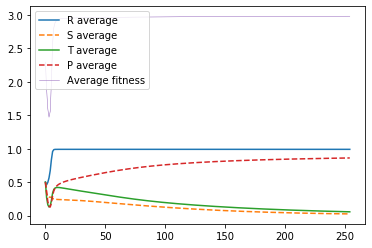

In [6]:
R = [r.dot(x_hist[i,:]) for i in range(len(x_hist))]
S = [s.dot(x_hist[i,:]) for i in range(len(x_hist))]
T = [t.dot(x_hist[i,:]) for i in range(len(x_hist))]
P = [p.dot(x_hist[i,:]) for i in range(len(x_hist))]
plt.plot(R, '-')
plt.plot(S, '--')
plt.plot(T, '-')
plt.plot(P, '--')

fitness = [x_hist[i,:].dot(payoff_matrix.dot(x_hist[i,:])) for i in range(len(x_hist))]
plt.plot(fitness, linewidth=0.5)

plt.legend(['R average', 'S average', 'T average', 'P average', 'Average fitness'])